In [11]:
import os
import pathlib
import random
import numpy as np
import matplotlib.pyplot as plt
 
import zipfile
import requests
import glob as glob
 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.utils import image_dataset_from_directory
 
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from dataclasses import dataclass

2024-09-12 18:47:23.580662: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-12 18:47:23.580686: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-12 18:47:23.581464: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-12 18:47:23.585885: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-12 18:47:24.417973: W tensorflow/compiler/tf2

In [12]:
SEED_VALUE = 41
 
# Fix seed to make training deterministic.
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

In [13]:
def download_file(url, save_name):
    url = url
    file = requests.get(url)
 
    open(save_name, 'wb').write(file.content)

In [14]:
def unzip(zip_file=None):
    try:
        with zipfile.ZipFile(zip_file) as z:
            z.extractall("./")
            print("Extracted all")
    except:
        print("Invalid file")

In [15]:
download_file( 
    'https://www.dropbox.com/s/41o9vh00rervwn9/dataset_traffic_signs_40_samples_per_class.zip?dl=1',
    'dataset_traffic_signs_40_samples_per_class.zip'
)
     
unzip(zip_file='dataset_traffic_signs_40_samples_per_class.zip')

Extracted all


In [16]:
@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES: int = 43
    IMG_HEIGHT:  int = 224
    IMG_WIDTH:   int = 224
    CHANNELS:    int = 3
         
    DATA_ROOT_TRAIN:  str = './dataset_traffic_signs_40_samples_per_class/Train' 
    DATA_ROOT_VALID:  str = './dataset_traffic_signs_40_samples_per_class/Valid'
    DATA_ROOT_TEST:   str = './dataset_traffic_signs_40_samples_per_class/Test'
    DATA_TEST_GT:     str = './dataset_traffic_signs_40_samples_per_class/Test.csv'
         
@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:       int   = 32
    EPOCHS:           int   = 101
    LEARNING_RATE:    float = 0.0001
    DROPOUT:          float = 0.6
    LAYERS_FINE_TUNE: int   = 8

In [17]:
train_dataset = image_dataset_from_directory(directory=DatasetConfig.DATA_ROOT_TRAIN,
                                             batch_size=TrainingConfig.BATCH_SIZE,
                                             shuffle=True,
                                             seed=SEED_VALUE,
                                             label_mode='int',        # Use integer encoding
                                             image_size=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH),
                                            )
 
valid_dataset = image_dataset_from_directory(directory=DatasetConfig.DATA_ROOT_VALID,
                                             batch_size=TrainingConfig.BATCH_SIZE,
                                             shuffle=True,
                                             seed=SEED_VALUE,
                                             label_mode='int',        # Use integer encoding
                                             image_size=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH),
                                            )

Found 1204 files belonging to 43 classes.


2024-09-12 18:47:31.729701: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-12 18:47:31.750965: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-12 18:47:31.751113: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Found 516 files belonging to 43 classes.


In [18]:
!nvidia-smi

Thu Sep 12 18:47:32 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        On  | 00000000:01:00.0 Off |                  Off |
|  0%   43C    P2              66W / 450W |  22664MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [19]:
print(train_dataset.class_names)

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '5', '6', '7', '8', '9']


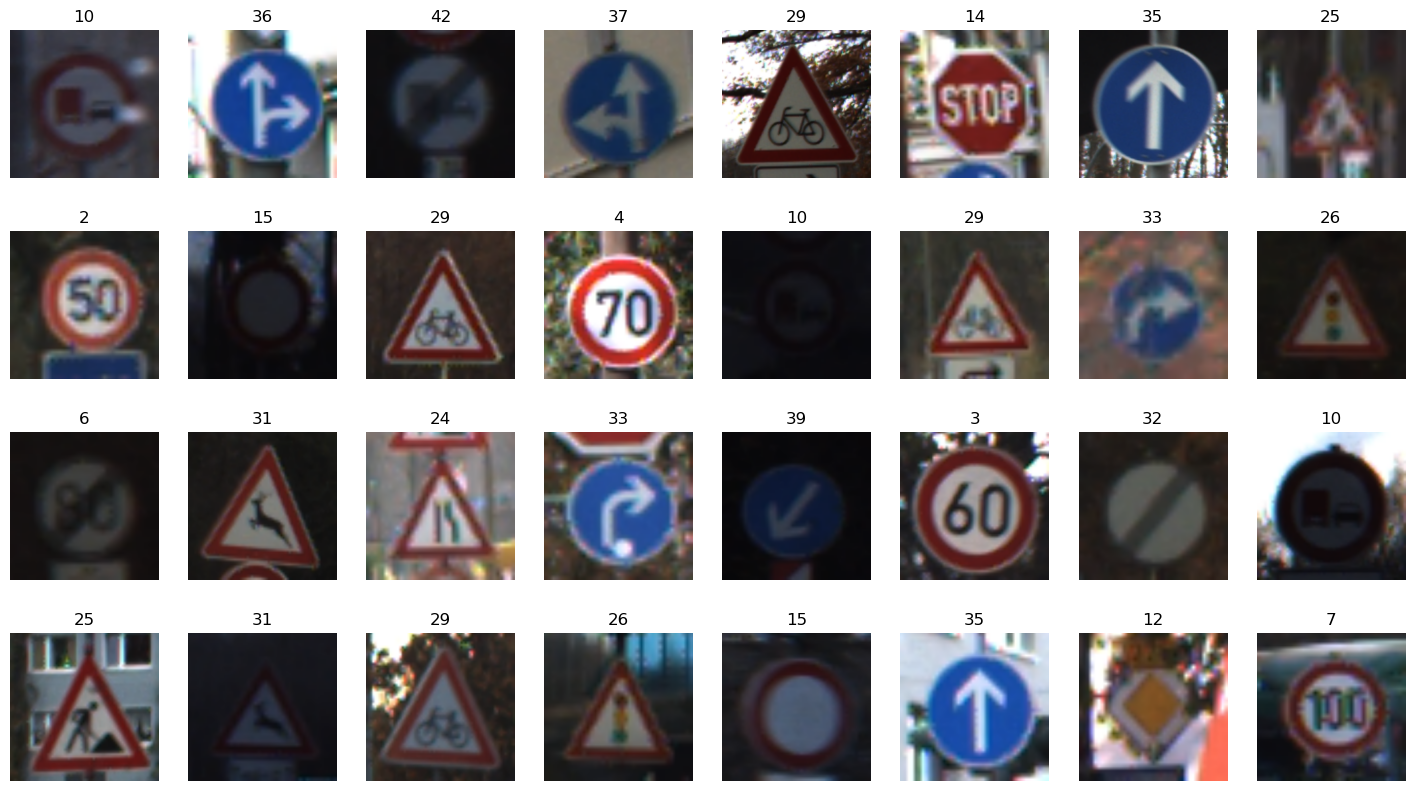

In [20]:
class_names = train_dataset.class_names
 
plt.figure(figsize=(18,10))
 
# Assumes dataset batch_size is at least 32.
num_rows = 4
num_cols = 8
 
# Here we use the take() method to retrieve just the first batch of data from the training portion of the dataset.
for image_batch, labels_batch in train_dataset.take(1): 
      
    # Plot each of the images in the batch and the associated ground truth labels.
    for i in range(num_rows*num_cols):
        ax = plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        truth_idx = labels_batch[i].numpy()
        plt.title(class_names[truth_idx])
        plt.axis("off")

In [21]:
import pandas as pd
 
input_file = DatasetConfig.DATA_TEST_GT
 
dataset = pd.read_csv(input_file)
df = pd.DataFrame(dataset)
cols = [6]
df = df[df.columns[cols]]
ground_truth_ids = df['ClassId'].values.tolist()
print("Total number of Test labels: ", len(ground_truth_ids))
print(ground_truth_ids[0:10])

Total number of Test labels:  12630
[16, 1, 38, 33, 11, 38, 18, 12, 25, 35]


In [22]:
print(train_dataset.class_names)

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '5', '6', '7', '8', '9']


In [23]:
# Convert train/valid class names to integers.
class_names_int = list(map(int, train_dataset.class_names))
 
# Create a dictionary mapping ground truth IDs to class name IDs.
gtid_2_cnidx = dict(zip(class_names_int, range(0,DatasetConfig.NUM_CLASSES)))
 
gtid_2_cnidx.items()

dict_items([(0, 0), (1, 1), (10, 2), (11, 3), (12, 4), (13, 5), (14, 6), (15, 7), (16, 8), (17, 9), (18, 10), (19, 11), (2, 12), (20, 13), (21, 14), (22, 15), (23, 16), (24, 17), (25, 18), (26, 19), (27, 20), (28, 21), (29, 22), (3, 23), (30, 24), (31, 25), (32, 26), (33, 27), (34, 28), (35, 29), (36, 30), (37, 31), (38, 32), (39, 33), (4, 34), (40, 35), (41, 36), (42, 37), (5, 38), (6, 39), (7, 40), (8, 41), (9, 42)])

In [24]:
# Convert the ground truth Class IDs to IDs that correctly map to the same classes 
# in the train and validation datasets.
label_ids = []
for idx in range(len(ground_truth_ids)):
    label_ids.append(gtid_2_cnidx[ground_truth_ids[idx]])
 
print('Original ground truth class IDs: ',ground_truth_ids[0:10])
print('New mapping required:            ',label_ids[0:10])
 
print('')
print('Train/Valid dataset class names: ',train_dataset.class_names)

Original ground truth class IDs:  [16, 1, 38, 33, 11, 38, 18, 12, 25, 35]
New mapping required:             [8, 1, 32, 27, 3, 32, 10, 4, 18, 29]

Train/Valid dataset class names:  ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '5', '6', '7', '8', '9']


In [25]:
# Get all the path names to the Test images (will prune later)
image_paths = sorted(glob.glob(DatasetConfig.DATA_ROOT_TEST + '/*.png'))
 
print(len(image_paths))
print('')
# Print the first 5 image paths to confirm.
for idx in range(5):
    print(image_paths[idx])

12630

./dataset_traffic_signs_40_samples_per_class/Test/00000.png
./dataset_traffic_signs_40_samples_per_class/Test/00001.png
./dataset_traffic_signs_40_samples_per_class/Test/00002.png
./dataset_traffic_signs_40_samples_per_class/Test/00003.png
./dataset_traffic_signs_40_samples_per_class/Test/00004.png


In [26]:
test_dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_ids))

In [27]:
def preprocess_image(image):
    # Decode and resize image.
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [DatasetConfig.IMG_WIDTH, DatasetConfig.IMG_HEIGHT])
    return image

In [28]:
def load_and_preprocess_image(path):
    # Read image into memory as a byte string.
    image = tf.io.read_file(path)
    return preprocess_image(image)

In [29]:
def load_and_preprocess_from_path_label(path, label):
    return load_and_preprocess_image(path), label

In [30]:
# Apply the functions above to the test dataset.
test_dataset = test_dataset.map(load_and_preprocess_from_path_label)
 
# Set the batch size for the dataset.
test_dataset = test_dataset.batch(TrainingConfig.BATCH_SIZE)

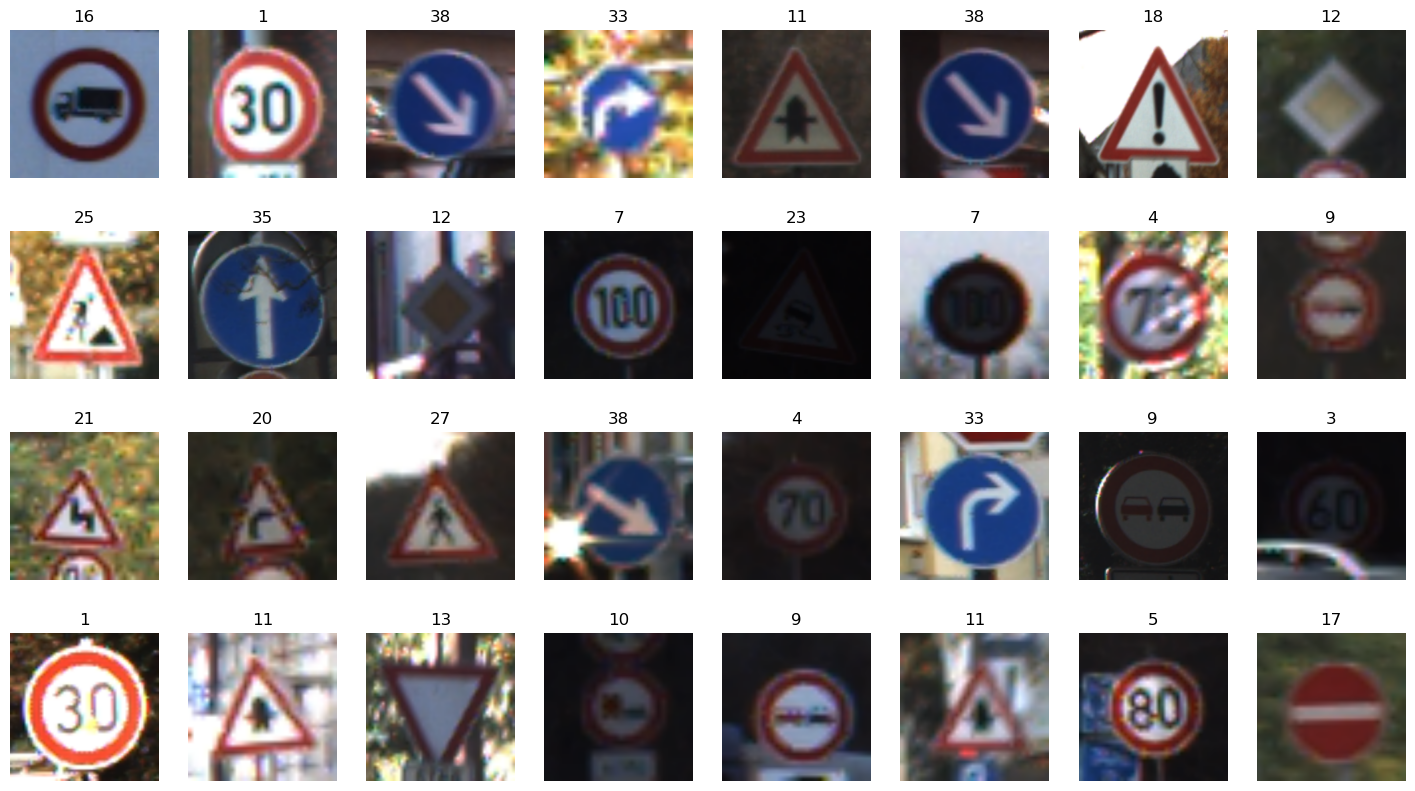

In [31]:
plt.figure(figsize=(18,10))
 
# Assumes dataset batch_size is at least 32.
num_rows = 4
num_cols = 8
 
# Here we use the take() method to retrieve just the first batch of data from the test dataset.
for image_batch, labels_batch in test_dataset.take(1):  
 
    # Plot each of the images in the batch and the associated ground truth labels.
    for i in range(num_rows*num_cols):
        ax = plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        truth_idx = labels_batch[i].numpy()
        plt.title(class_names[truth_idx])
        plt.axis("off")

In [32]:
# Specify the model input shape.
input_shape = (DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH, DatasetConfig.CHANNELS)
 
print('Loading model with ImageNet weights...')
vgg16_conv_base = tf.keras.applications.vgg16.VGG16(input_shape=input_shape,
                                                    include_top=False, # We will supply our own top.
                                                    weights='imagenet',
                                                   )
print(vgg16_conv_base.summary())

Loading model with ImageNet weights...
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooli

In [33]:
# Set all layers in the convolutional base to Trainable (will FREEZE initial layers further below).
vgg16_conv_base.trainable = True
 
# Specify the number of layers to fine tune at the end of the convolutional base.
num_layers_fine_tune = TrainingConfig.LAYERS_FINE_TUNE
num_layers = len(vgg16_conv_base.layers)
 
# Freeze the initial layers in the convolutional base.
for model_layer in vgg16_conv_base.layers[:num_layers - num_layers_fine_tune]:
    print(f"FREEZING LAYER: {model_layer}")
    model_layer.trainable = False
 
print("\n")
print(f"Configured to fine tune the last", num_layers_fine_tune, "convolutional layers...")
print("\n")
     
print(vgg16_conv_base.summary())

FREEZING LAYER: <keras.src.engine.input_layer.InputLayer object at 0x7fc08bbd2ad0>
FREEZING LAYER: <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7fc094737290>
FREEZING LAYER: <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7fbfc0dc1510>
FREEZING LAYER: <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7fc094792650>
FREEZING LAYER: <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7fbfc0dd19d0>
FREEZING LAYER: <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7fbfc0c0ab10>
FREEZING LAYER: <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7fc094a1fd90>
FREEZING LAYER: <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7fbfc0dd2550>
FREEZING LAYER: <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7fc0949ae510>
FREEZING LAYER: <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7fc094808a10>
FREEZING LAYER: <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7fbfc0dd22d0>


Configured to 

In [34]:
inputs = tf.keras.Input(shape=input_shape)
     
x = tf.keras.applications.vgg16.preprocess_input(inputs)
     
x = vgg16_conv_base(x)
 
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(TrainingConfig.DROPOUT)(x)
     
# The final `Dense` layer with the number of classes.
outputs = layers.Dense(DatasetConfig.NUM_CLASSES, activation='softmax')(x)
     
# The final model.
model_vgg16_finetune = keras.Model(inputs, outputs)
 
print(model_vgg16_finetune.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               321139

In [56]:
# Use this for integer encoded labels.
model_vgg16_finetune.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=TrainingConfig.LEARNING_RATE),
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                    metrics=['accuracy'],
                   )

In [57]:
# Train the Model.
training_results = model_vgg16_finetune.fit(train_dataset,
                                            epochs=TrainingConfig.EPOCHS,
                                            validation_data=valid_dataset,
                                           )

Epoch 1/101
38/38 [==============================] - 5s 74ms/step - loss: 4.0778 - accuracy: 0.0282 - val_loss: 3.7307 - val_accuracy: 0.0426
Epoch 2/101
38/38 [==============================] - 2s 46ms/step - loss: 3.6711 - accuracy: 0.0490 - val_loss: 3.5843 - val_accuracy: 0.0988
Epoch 3/101
38/38 [==============================] - 2s 45ms/step - loss: 3.4831 - accuracy: 0.1063 - val_loss: 3.3948 - val_accuracy: 0.1143
Epoch 4/101
38/38 [==============================] - 2s 44ms/step - loss: 3.1053 - accuracy: 0.1952 - val_loss: 2.7471 - val_accuracy: 0.2829
Epoch 5/101
38/38 [==============================] - 2s 46ms/step - loss: 2.6534 - accuracy: 0.3032 - val_loss: 2.2431 - val_accuracy: 0.4089
Epoch 6/101
38/38 [==============================] - 2s 45ms/step - loss: 2.2498 - accuracy: 0.3879 - val_loss: 1.9883 - val_accuracy: 0.4554
Epoch 7/101
38/38 [==============================] - 2s 45ms/step - loss: 1.9113 - accuracy: 0.4809 - val_loss: 1.7392 - val_accuracy: 0.5504
Epoch 

In [58]:
def plot_results(metrics, ylabel=None, ylim=None, metric_name=None, color=None):
     
    fig, ax = plt.subplots(figsize=(15, 4))
 
    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]
         
    for idx, metric in enumerate(metrics):    
        ax.plot(metric, color=color[idx])
     
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(ylabel)
    plt.xlim([0, TrainingConfig.EPOCHS-1])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)   
    plt.show()
    plt.close()

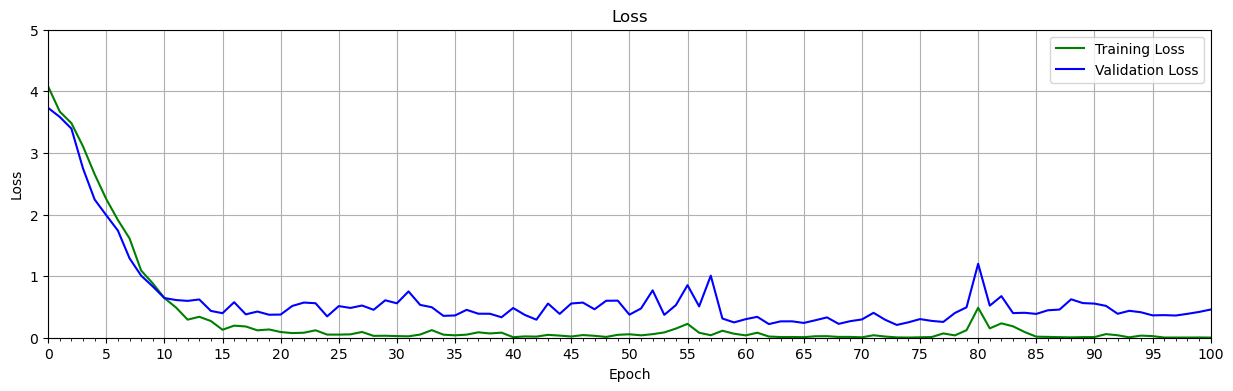

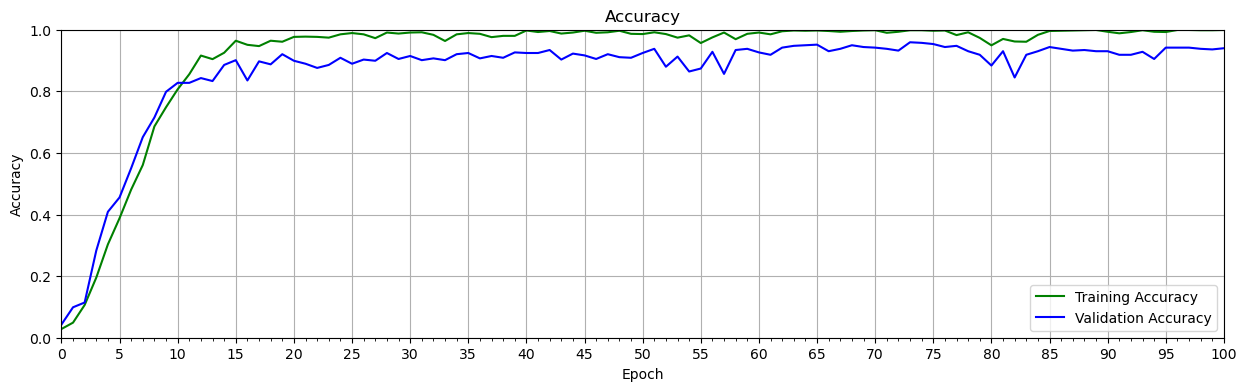

In [59]:
# Retrieve training results.
train_loss = training_results.history["loss"]
train_acc  = training_results.history["accuracy"]
valid_loss = training_results.history["val_loss"]
valid_acc  = training_results.history["val_accuracy"]
     
plot_results([ train_loss, valid_loss ],        
            ylabel="Loss", 
            ylim = [0.0, 5.0],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);
 
plot_results([ train_acc, valid_acc ], 
            ylabel="Accuracy",
            ylim = [0.0, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])

In [60]:
print(f"Model valid accuracy: {model_vgg16_finetune.evaluate(valid_dataset)[1]*100.:.3f}")

17/17 [==============================] - 1s 29ms/step - loss: 0.4578 - accuracy: 0.9399
Model valid accuracy: 93.992


In [61]:
print(f"Model test accuracy: {model_vgg16_finetune.evaluate(test_dataset)[1]*100.:.3f}")

395/395 [==============================] - 11s 27ms/step - loss: 0.2900 - accuracy: 0.9585
Model test accuracy: 95.851


In [62]:
def display_predictions(dataset, model, class_names):
     
    plt.figure(figsize=(20,20))
    num_rows = 8
    num_cols = 8
    jdx = 0
     
    # Evaluate all the batches.
    for image_batch, labels_batch in dataset.take(2):
         
        print(image_batch.shape)
         
        # Predictions for the current batch.
        predictions = model.predict(image_batch)
         
        # Loop over all the images in the current batch.
        for idx in range(len(labels_batch)):
             
            pred_idx = tf.argmax(predictions[idx]).numpy()
            truth_idx = labels_batch[idx].numpy()
             
            # Set the title color based on the prediction.
            if pred_idx == truth_idx:
                color='g'
            else:
                color='r'
                 
            jdx += 1
                 
            if jdx > num_rows*num_cols:
                # Break from the loops if the maximum number of images have been plotted
                break
                 
            ax = plt.subplot(num_rows, num_cols, jdx)
            title = str(class_names[truth_idx]) + " : " + str(class_names[pred_idx])
                 
            title_obj = plt.title(title)
            plt.setp(title_obj, color=color)
            plt.axis("off")
            plt.imshow(image_batch[idx].numpy().astype("uint8"));
    return

(32, 224, 224, 3)
1/1 [==============================] - 0s 110ms/step
(32, 224, 224, 3)
1/1 [==============================] - 0s 16ms/step


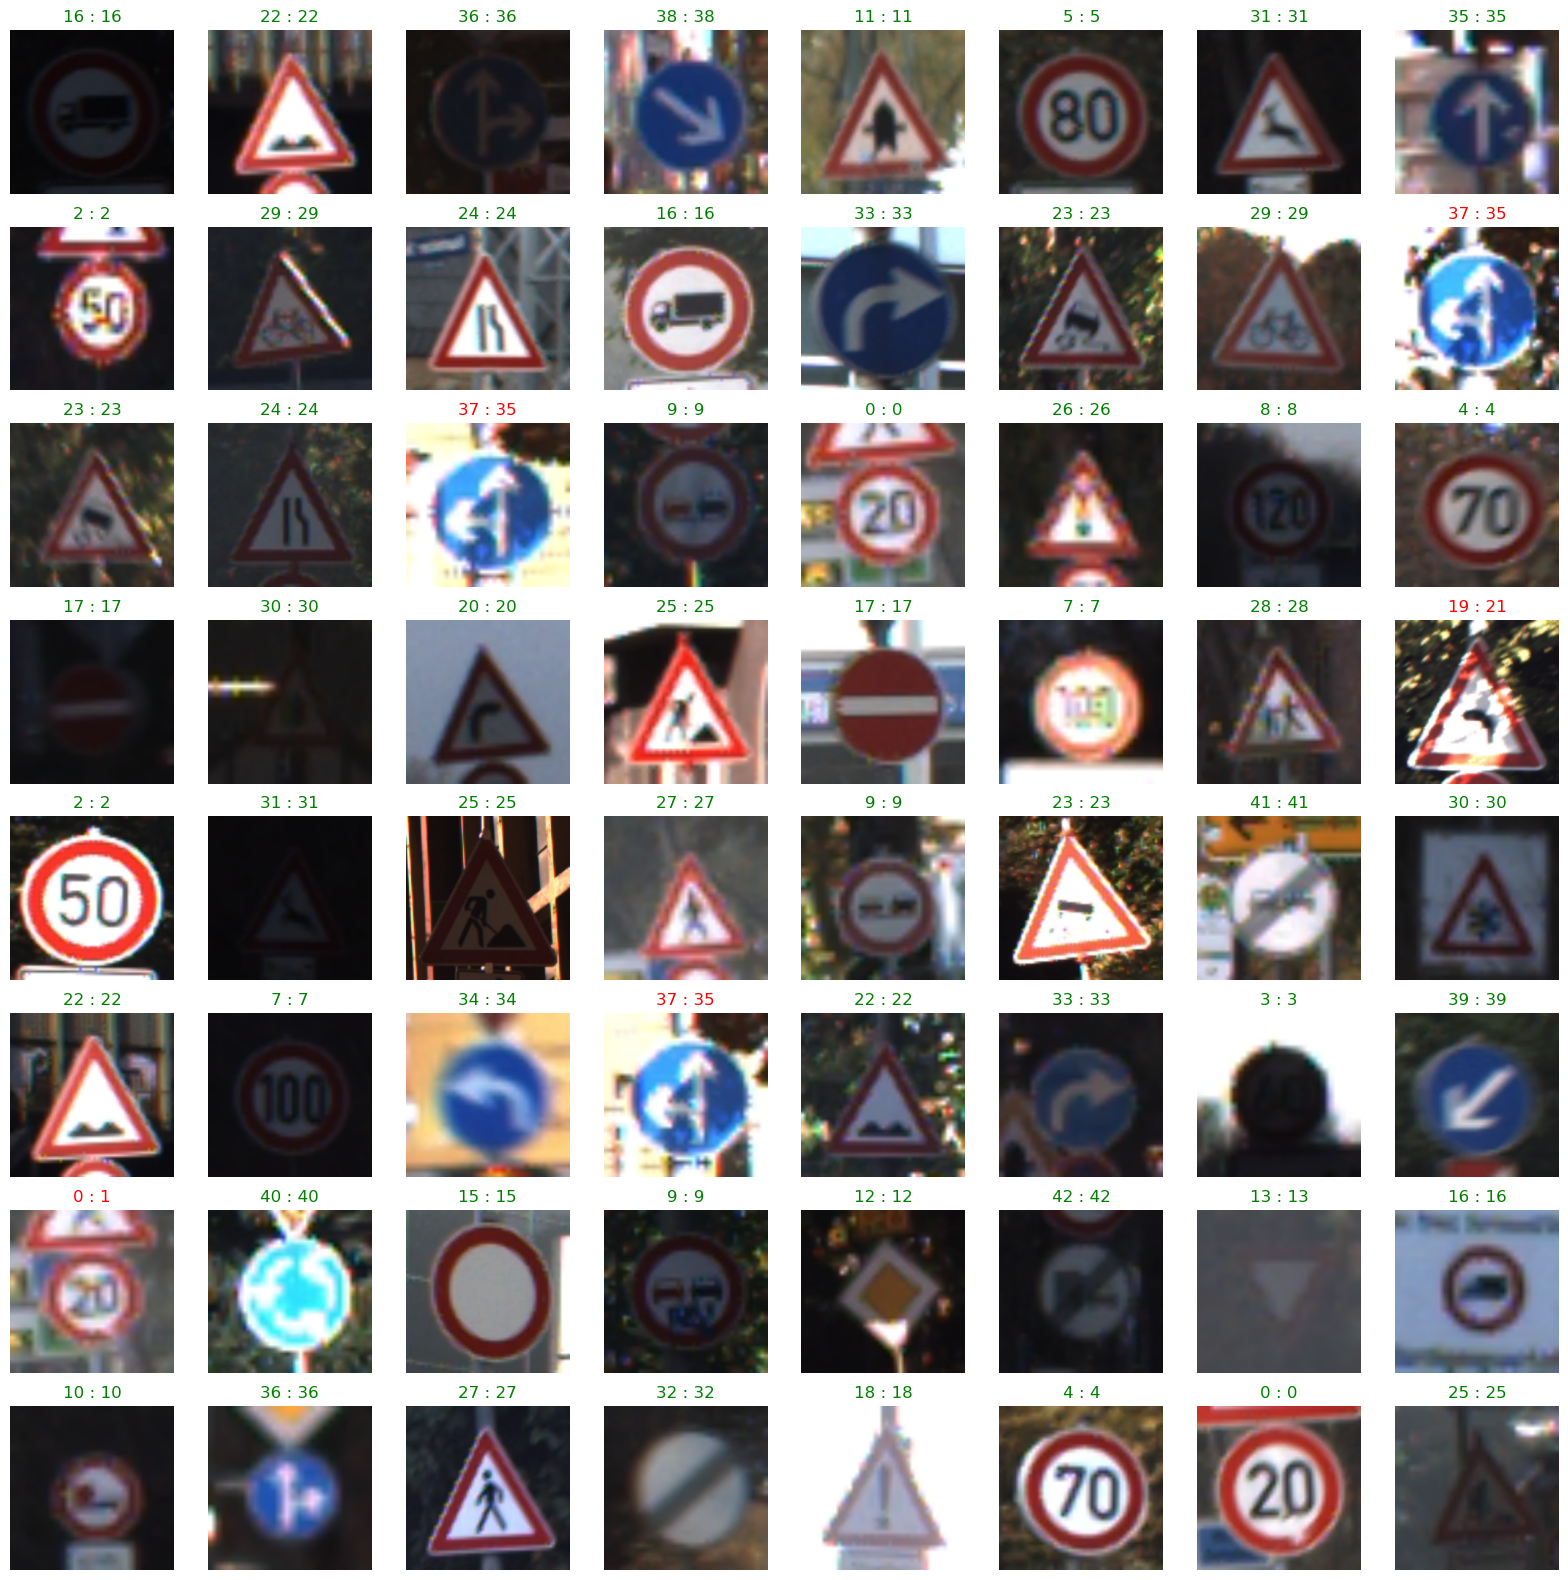

In [63]:
display_predictions(valid_dataset, model_vgg16_finetune, class_names)

(32, 224, 224, 3)
1/1 [==============================] - 0s 25ms/step
(32, 224, 224, 3)
1/1 [==============================] - 0s 51ms/step


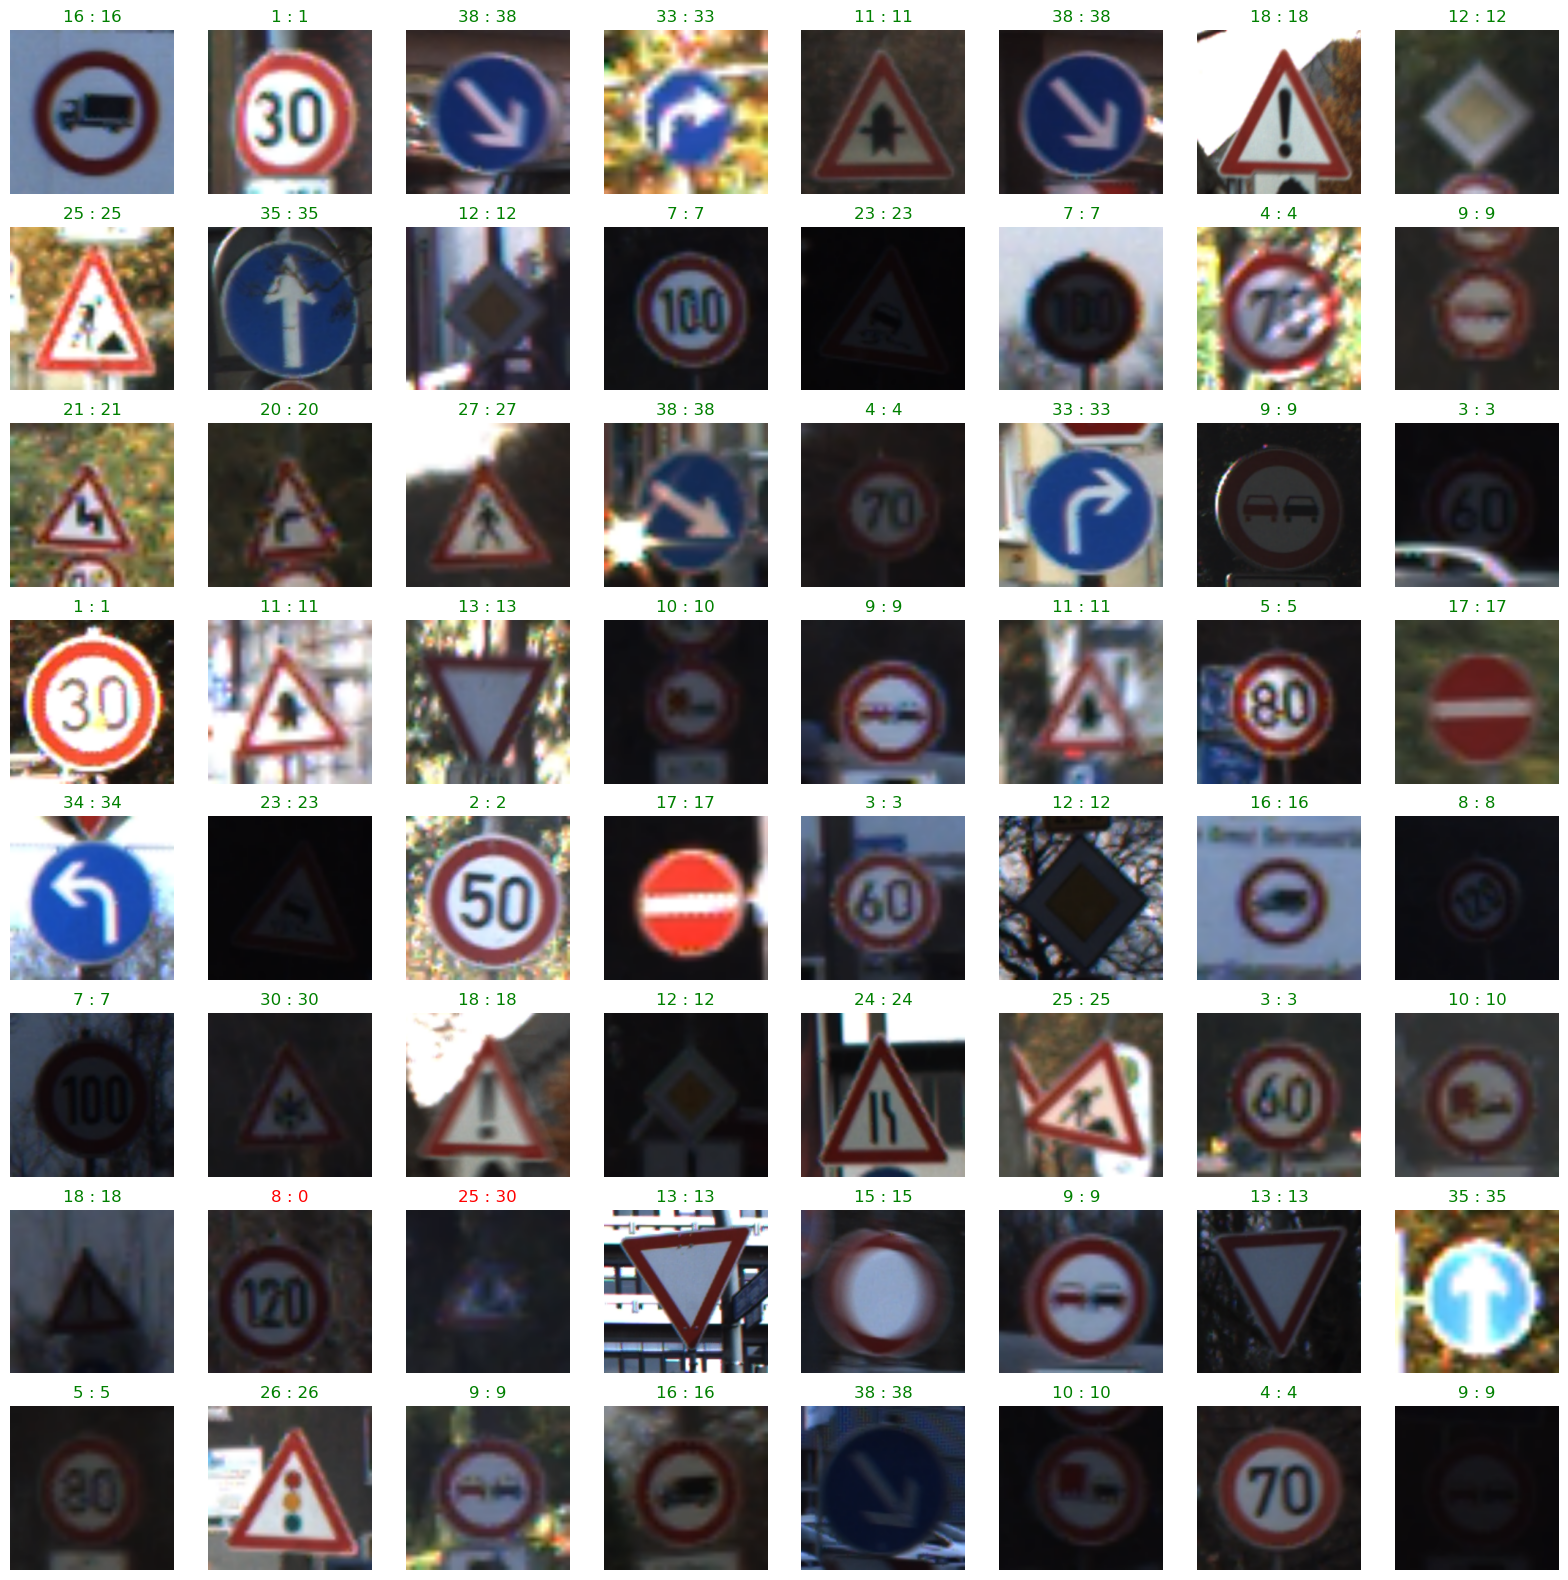

In [64]:
display_predictions(test_dataset, model_vgg16_finetune, class_names)